In [1]:
import numpy as np
from scipy.stats import skewnorm, t, norm, expon, gamma, beta, chi2, uniform
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import warnings
from joblib import Parallel, delayed
from utils import *

In [2]:
# Распределения для H0 и H1
DISTRIBUTION_H0 = "skewnorm"  # Распределение под гипотезой H0
DISTRIBUTION_H1 = "student_t"  # Распределение под гипотезой H1

# Параметры распределений (θ₀ и υ₀ из задания)
PARAMS_H0 = {"alpha": 1}  # Для skewnorm: alpha - параметр асимметрии
PARAMS_H1 = {"nu": 3}  # Для student_t: nu - степени свободы

# Тип графа (выбираем один согласно заданию)
GRAPH_TYPE = "knn"  # Используем KNN-граф
K_VALUE = 5  # Параметр k для KNN-графа
#D_VALUE = 0.5  # Параметр d для dist-графа

# Размеры выборок согласно заданию
N_VALUES = [25, 100, 500]

# Количество выборок для обучения каждого класса
N_SAMPLES_PER_CLASS = 5000

# Количество бутстреп-итераций для оценки дисперсии
N_BOOTSTRAP = 30

# Количество фолдов для кросс-валидации
CV_FOLDS = 5

# Случайное зерно
RANDOM_STATE = 42

# Количество параллельных процессов
N_JOBS = -1

# Характеристики графов для анализа
FEATURES_TO_USE = [
    #"max_degree",  # Δ(G)
    #"min_degree",  # δ(G)
    "num_components",  # c(G)
    "triangle_count",  # t(G)
    # Можно добавить другие характеристики:
    # "articulation_points",
    # "average_degree",
    # "density",
    # "clustering_coefficient",
    # "diameter",
    # "edge_connectivity",
    "clique_number",
]

In [3]:
print("=" * 70)
print("ПАРАМЕТРЫ ЭКСПЕРИМЕНТА (Часть II)")
print("=" * 70)
print(f"H0: {DISTRIBUTION_H0} с параметрами {PARAMS_H0}")
print(f"H1: {DISTRIBUTION_H1} с параметрами {PARAMS_H1}")
print(f"Тип графа: {GRAPH_TYPE.upper()}")
print(f"Параметр k = {K_VALUE}")
print(f"Размеры выборок: {N_VALUES}")
print(f"Количество выборок на класс: {N_SAMPLES_PER_CLASS}")
print(f"Исследуемые характеристики: {', '.join(FEATURES_TO_USE)}")
print("=" * 70)

ПАРАМЕТРЫ ЭКСПЕРИМЕНТА (Часть II)
H0: skewnorm с параметрами {'alpha': 1}
H1: student_t с параметрами {'nu': 3}
Тип графа: KNN
Параметр k = 5
Размеры выборок: [25, 100, 500]
Количество выборок на класс: 5000
Исследуемые характеристики: num_components, triangle_count, clique_number


In [4]:
def extract_features(data, graph_type="knn", k=5, features_to_use=None):
    """Извлечение выбранных характеристик из графа"""
    if features_to_use is None:
        features_to_use = FEATURES_TO_USE

    # Построение графа
    if graph_type == "knn":
        G = build_knn_graph(data, k)
    else:
        G = build_distance_graph(data, d)

    # Словарь функций для вычисления характеристик
    feature_functions = {
        "max_degree": lambda: safe_compute(max_degree, G),
        "min_degree": lambda: safe_compute(min_degree, G),
        "num_components": lambda: safe_compute(num_components, G),
        "articulation_points": lambda: safe_compute(articulation_points, G),
        "triangle_count": lambda: safe_compute(triangle_count, G),
        "average_degree": lambda: safe_compute(average_degree, G),
        "density": lambda: safe_compute(density, G),
        "clustering_coefficient": lambda: safe_compute(clustering_coefficient, G),
        "diameter": lambda: safe_compute(diameter_largest_component, G),
        "edge_connectivity": lambda: safe_compute(edge_connectivity, G),
        "clique_number": lambda: safe_compute(clique_number, G),
    }

    # Извлекаем только выбранные характеристики
    features = {}
    for feature_name in features_to_use:
        if feature_name in feature_functions:
            features[feature_name] = feature_functions[feature_name]()

    return features


def generate_single_sample(generator, n, graph_type, k, features_to_use):
    """Генерация одной выборки и извлечение признаков"""
    data = generator(n)
    features = extract_features(data, graph_type=graph_type, k=k, features_to_use=features_to_use)
    return list(features.values())

In [5]:
print("=" * 70)
print("ПАРАМЕТРЫ ЭКСПЕРИМЕНТА")
print("=" * 70)
print(f"H0: {DISTRIBUTION_H0} с параметрами {PARAMS_H0}")
print(f"H1: {DISTRIBUTION_H1} с параметрами {PARAMS_H1}")
print(f"Тип графа: {GRAPH_TYPE}")
if GRAPH_TYPE == "knn":
    print(f"Параметр k = {K_VALUE}")
else:
    print(f"Параметр d = {D_VALUE}")
print(f"Размеры выборок: {N_VALUES}")
print(f"Количество выборок на класс: {N_SAMPLES_PER_CLASS}")
print(f"Исследуемые характеристики ({len(FEATURES_TO_USE)}): {', '.join(FEATURES_TO_USE)}")
print("=" * 70)

ПАРАМЕТРЫ ЭКСПЕРИМЕНТА
H0: skewnorm с параметрами {'alpha': 1}
H1: student_t с параметрами {'nu': 3}
Тип графа: knn
Параметр k = 5
Размеры выборок: [25, 100, 500]
Количество выборок на класс: 5000
Исследуемые характеристики (3): num_components, triangle_count, clique_number


In [6]:
generator_h0 = get_generator(DISTRIBUTION_H0, PARAMS_H0)
generator_h1 = get_generator(DISTRIBUTION_H1, PARAMS_H1)

# Словарь для хранения всех датасетов
all_datasets = {}

print("\n=== ГЕНЕРАЦИЯ ДАТАСЕТОВ ===")
for n in N_VALUES:
    print(f"\nГенерация данных для n={n}...")

    # Параллельная генерация выборок для H0
    samples_h0 = Parallel(n_jobs=N_JOBS)(
        delayed(generate_single_sample)(generator_h0, n, GRAPH_TYPE, K_VALUE, FEATURES_TO_USE)
        for _ in tqdm(range(N_SAMPLES_PER_CLASS), desc=f"H0 (n={n})")
    )

    # Параллельная генерация выборок для H1
    samples_h1 = Parallel(n_jobs=N_JOBS)(
        delayed(generate_single_sample)(generator_h1, n, GRAPH_TYPE, K_VALUE, FEATURES_TO_USE)
        for _ in tqdm(range(N_SAMPLES_PER_CLASS), desc=f"H1 (n={n})")
    )

    # Объединение данных
    X = np.vstack([samples_h0, samples_h1])
    y = np.hstack([np.zeros(N_SAMPLES_PER_CLASS), np.ones(N_SAMPLES_PER_CLASS)])

    # Сохраняем датасет
    all_datasets[n] = {"X": X, "y": y, "feature_names": FEATURES_TO_USE}

    print(f"Датасет для n={n}: форма X = {X.shape}, форма y = {y.shape}")


=== ГЕНЕРАЦИЯ ДАТАСЕТОВ ===

Генерация данных для n=25...


H1 (n=25): 100%|██████████| 5000/5000 [00:00<00:00, 18523.53it/s]


Датасет для n=25: форма X = (10000, 3), форма y = (10000,)

Генерация данных для n=100...


H1 (n=100): 100%|██████████| 5000/5000 [00:00<00:00, 7934.58it/s]


Датасет для n=100: форма X = (10000, 3), форма y = (10000,)

Генерация данных для n=500...


H1 (n=500): 100%|██████████| 5000/5000 [00:04<00:00, 1216.47it/s]


Датасет для n=500: форма X = (10000, 3), форма y = (10000,)


In [7]:
print("\n=== АНАЛИЗ ВАЖНОСТИ ХАРАКТЕРИСТИК ===")

feature_importance_dict = {}

for n in N_VALUES:
    print(f"\n--- Анализ для n={n} ---")

    # Извлекаем данные
    X = all_datasets[n]["X"]
    y = all_datasets[n]["y"]
    feature_names = all_datasets[n]["feature_names"]

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

    # Нормализация
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Обучение Random Forest для оценки важности признаков
    rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    rf.fit(X_train_scaled, y_train)

    # Сохранение важности признаков
    feature_importance = pd.DataFrame({"feature": feature_names, "importance": rf.feature_importances_}).sort_values(
        "importance", ascending=False
    )

    feature_importance_dict[n] = feature_importance

    print(f"\nВажность признаков для n={n}:")
    print(feature_importance)


=== АНАЛИЗ ВАЖНОСТИ ХАРАКТЕРИСТИК ===

--- Анализ для n=25 ---

Важность признаков для n=25:
          feature  importance
1  triangle_count    0.847643
0  num_components    0.110382
2   clique_number    0.041976

--- Анализ для n=100 ---

Важность признаков для n=100:
          feature  importance
1  triangle_count    0.693230
0  num_components    0.279102
2   clique_number    0.027668

--- Анализ для n=500 ---

Важность признаков для n=500:
          feature  importance
1  triangle_count    0.621453
0  num_components    0.365853
2   clique_number    0.012693


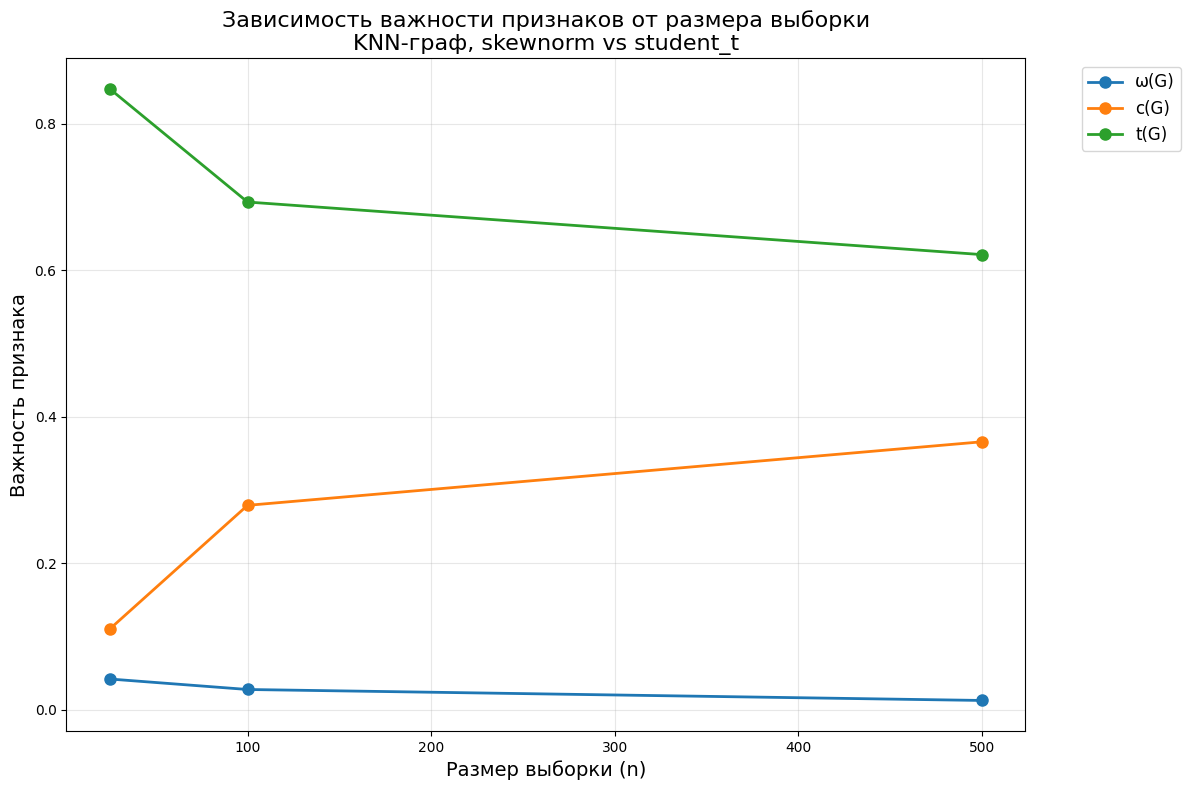

In [8]:
feature_labels = {
    "max_degree": "Δ(G)",
    "min_degree": "δ(G)",
    "num_components": "c(G)",
    "articulation_points": "a(G)",
    "triangle_count": "t(G)",
    "average_degree": "d̄(G)",
    "density": "ρ(G)",
    "clustering_coefficient": "C(G)",
    "diameter": "diam(G)",
    "edge_connectivity": "λ(G)",
    "clique_number": "ω(G)",
}

# Подготовка данных для визуализации
records = []
for n, df in feature_importance_dict.items():
    for _, row in df.iterrows():
        records.append({"n": n, "feature": row["feature"], "importance": row["importance"]})

imp_df = pd.DataFrame(records)
pivot_df = imp_df.pivot(index="n", columns="feature", values="importance")

# Построение графика
plt.figure(figsize=(12, 8))
for feature in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[feature],
        marker="o",
        label=feature_labels.get(feature, feature),
        linewidth=2,
        markersize=8,
    )

plt.xlabel("Размер выборки (n)", fontsize=14)
plt.ylabel("Важность признака", fontsize=14)
plt.title(
    f"Зависимость важности признаков от размера выборки\n"
    f"{GRAPH_TYPE.upper()}-граф, {DISTRIBUTION_H0} vs {DISTRIBUTION_H1}",
    fontsize=16,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    #"Neural Network": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=RANDOM_STATE),
}

In [10]:
def evaluate_classifier_single_run(clf, X_train, X_test, y_train, y_test):
    """Одиночный запуск оценки классификатора"""
    # Обучение
    clf_copy = clf.__class__(**clf.get_params())
    clf_copy.fit(X_train, y_train)

    # Предсказания
    y_pred = clf_copy.predict(X_test)
    y_pred_proba = clf_copy.predict_proba(X_test)[:, 1] if hasattr(clf_copy, "predict_proba") else None

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = 0.5

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Ошибка первого рода (α) и мощность (1-β)
    type_i_error = fp / (fp + tn) if (fp + tn) > 0 else 0
    power = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "type_i_error": type_i_error,
        "power": power,
    }


def evaluate_classifier_with_variance(clf, X, y, n_bootstrap=30):
    """Оценка классификатора с бутстрепом для оценки дисперсии"""
    results = []

    for i in range(n_bootstrap):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=RANDOM_STATE + i, stratify=y
        )

        metrics = evaluate_classifier_single_run(clf, X_train, X_test, y_train, y_test)
        results.append(metrics)

    results_df = pd.DataFrame(results)

    # Вычисляем статистики для каждой метрики
    final_metrics = {}
    for metric in results_df.columns:
        values = results_df[metric].values
        final_metrics[metric] = {
            "mean": np.mean(values),
            "std": np.std(values),
            "min": np.min(values),
            "max": np.max(values),
        }

    return final_metrics

In [11]:
detailed_results = {n: {} for n in N_VALUES}

print("\n" + "=" * 70)
print("ОЦЕНКА КЛАССИФИКАТОРОВ С АНАЛИЗОМ ДИСПЕРСИИ")
print("=" * 70)

for n in N_VALUES:
    print(f"\n{'='*50}")
    print(f"Оценка для n={n}")
    print(f"Количество бутстреп-итераций: {N_BOOTSTRAP}")
    print("=" * 50)

    # Извлекаем данные
    X = all_datasets[n]["X"]
    y = all_datasets[n]["y"]

    # Нормализация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Оценка каждого классификатора
    for clf_name, clf in classifiers.items():
        print(f"\nОценка {clf_name}...")
        metrics = evaluate_classifier_with_variance(clf, X_scaled, y, N_BOOTSTRAP)
        detailed_results[n][clf_name] = metrics

        print(f"  Accuracy:     {metrics['accuracy']['mean']:.4f} ± {metrics['accuracy']['std']:.4f}")
        print(f"  Precision:    {metrics['precision']['mean']:.4f} ± {metrics['precision']['std']:.4f}")
        print(f"  Recall:       {metrics['recall']['mean']:.4f} ± {metrics['recall']['std']:.4f}")
        print(f"  F1-Score:     {metrics['f1']['mean']:.4f} ± {metrics['f1']['std']:.4f}")
        print(f"  ROC-AUC:      {metrics['roc_auc']['mean']:.4f} ± {metrics['roc_auc']['std']:.4f}")
        print(f"  Ошибка I рода: {metrics['type_i_error']['mean']:.4f} ± {metrics['type_i_error']['std']:.4f}")
        print(f"  Мощность:     {metrics['power']['mean']:.4f} ± {metrics['power']['std']:.4f}")


ОЦЕНКА КЛАССИФИКАТОРОВ С АНАЛИЗОМ ДИСПЕРСИИ

Оценка для n=25
Количество бутстреп-итераций: 30

Оценка Random Forest...
  Accuracy:     0.8602 ± 0.0044
  Precision:    0.8711 ± 0.0124
  Recall:       0.8460 ± 0.0161
  F1-Score:     0.8582 ± 0.0051
  ROC-AUC:      0.9434 ± 0.0029
  Ошибка I рода: 0.1256 ± 0.0158
  Мощность:     0.8460 ± 0.0161

Оценка SVM (RBF)...
  Accuracy:     0.6845 ± 0.0091
  Precision:    0.6318 ± 0.0073
  Recall:       0.8850 ± 0.0177
  F1-Score:     0.7371 ± 0.0083
  ROC-AUC:      0.7736 ± 0.0099
  Ошибка I рода: 0.5160 ± 0.0183
  Мощность:     0.8850 ± 0.0177

Оценка Logistic Regression...
  Accuracy:     0.6791 ± 0.0099
  Precision:    0.6845 ± 0.0123
  Recall:       0.6651 ± 0.0135
  F1-Score:     0.6745 ± 0.0098
  ROC-AUC:      0.6717 ± 0.0072
  Ошибка I рода: 0.3069 ± 0.0180
  Мощность:     0.6651 ± 0.0135

Оценка для n=100
Количество бутстреп-итераций: 30

Оценка Random Forest...
  Accuracy:     0.9508 ± 0.0030
  Precision:    0.9555 ± 0.0091
  Recall:    

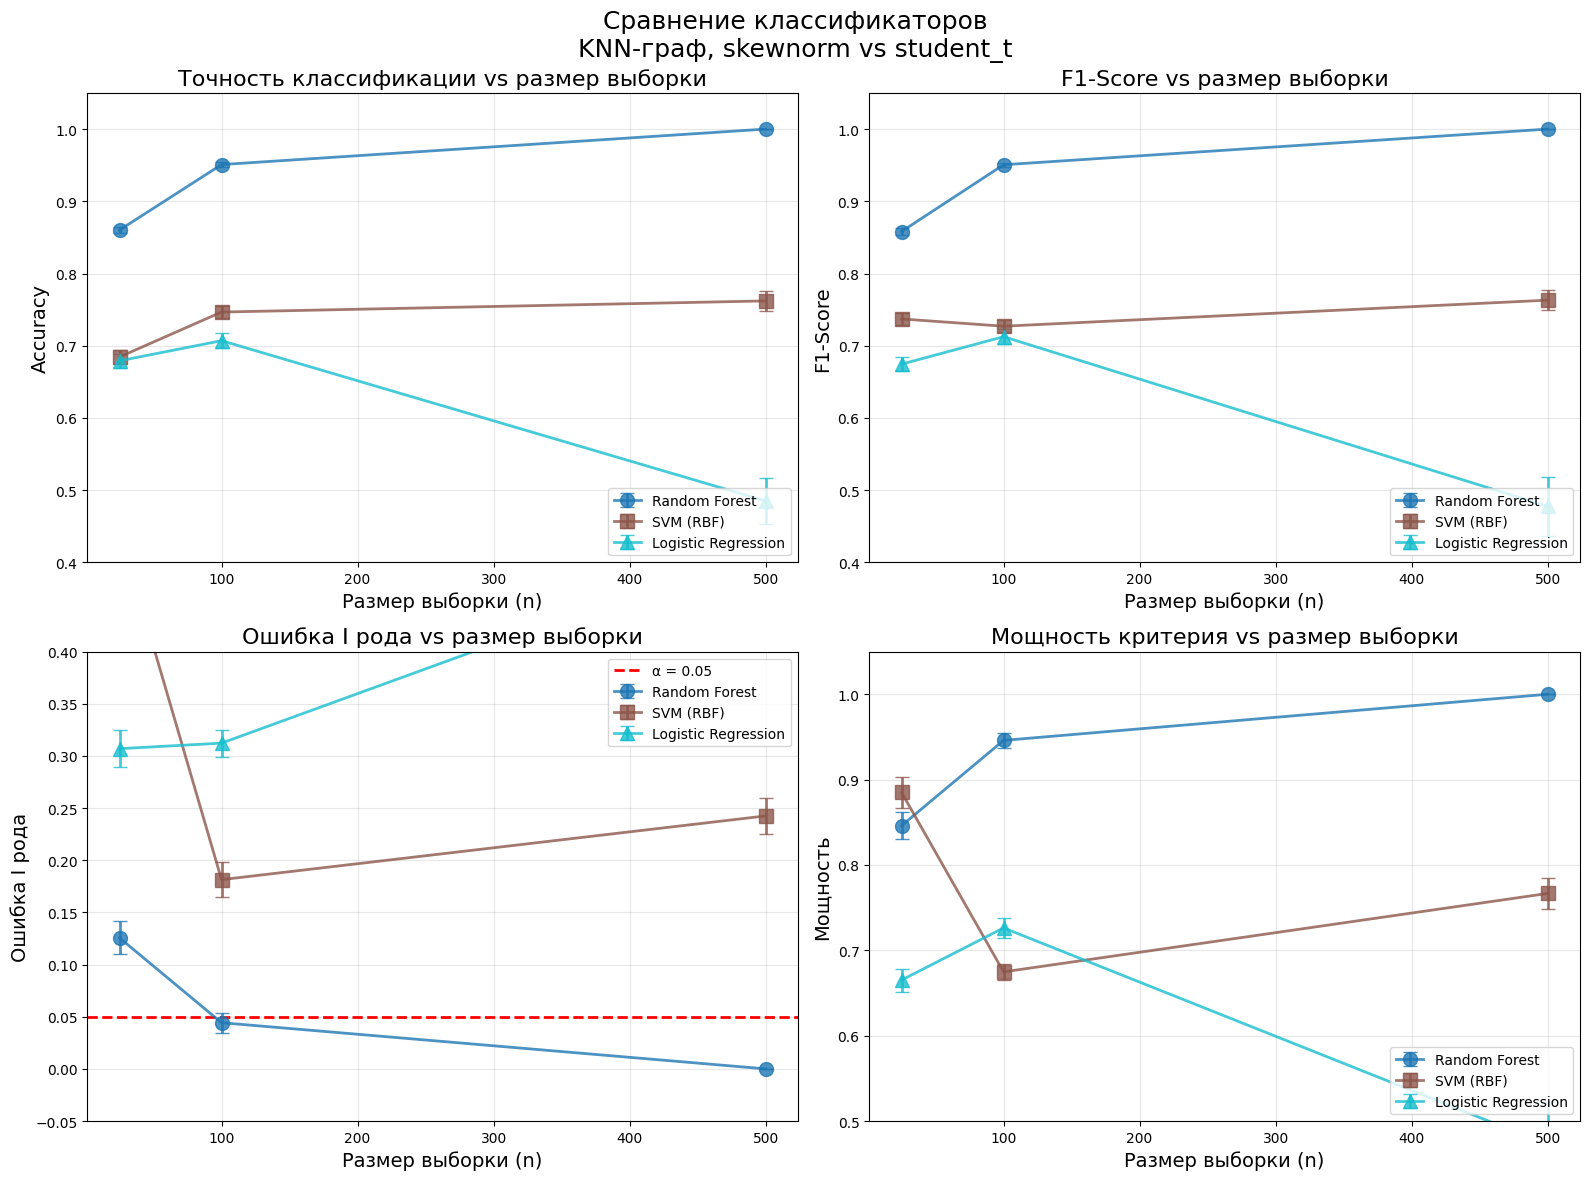

In [15]:
metrics_list = []
for n in N_VALUES:
    for clf_name, metrics in detailed_results[n].items():
        metrics_list.append(
            {
                "n": n,
                "Classifier": clf_name,
                "Accuracy": metrics["accuracy"]["mean"],
                "Accuracy_std": metrics["accuracy"]["std"],
                "F1-Score": metrics["f1"]["mean"],
                "F1_std": metrics["f1"]["std"],
                "Type I Error": metrics["type_i_error"]["mean"],
                "Type I Error_std": metrics["type_i_error"]["std"],
                "Power": metrics["power"]["mean"],
                "Power_std": metrics["power"]["std"],
            }
        )

results_df = pd.DataFrame(metrics_list)

# График с error bars
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Стиль для графиков
colors = plt.cm.tab10(np.linspace(0, 1, len(classifiers)))
markers = ["o", "s", "^", "D", "v"]

# Accuracy
ax = axes[0, 0]
for i, clf_name in enumerate(classifiers.keys()):
    clf_data = results_df[results_df["Classifier"] == clf_name]
    ax.errorbar(
        clf_data["n"],
        clf_data["Accuracy"],
        yerr=clf_data["Accuracy_std"],
        marker=markers[i],
        color=colors[i],
        label=clf_name,
        capsize=5,
        linewidth=2,
        markersize=10,
        alpha=0.8,
    )
ax.set_xlabel("Размер выборки (n)", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Точность классификации vs размер выборки", fontsize=16)
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0.4, 1.05)

# F1-Score
ax = axes[0, 1]
for i, clf_name in enumerate(classifiers.keys()):
    clf_data = results_df[results_df["Classifier"] == clf_name]
    ax.errorbar(
        clf_data["n"],
        clf_data["F1-Score"],
        yerr=clf_data["F1_std"],
        marker=markers[i],
        color=colors[i],
        label=clf_name,
        capsize=5,
        linewidth=2,
        markersize=10,
        alpha=0.8,
    )
ax.set_xlabel("Размер выборки (n)", fontsize=14)
ax.set_ylabel("F1-Score", fontsize=14)
ax.set_title("F1-Score vs размер выборки", fontsize=16)
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0.4, 1.05)

# Type I Error
ax = axes[1, 0]
for i, clf_name in enumerate(classifiers.keys()):
    clf_data = results_df[results_df["Classifier"] == clf_name]
    ax.errorbar(
        clf_data["n"],
        clf_data["Type I Error"],
        yerr=clf_data["Type I Error_std"],
        marker=markers[i],
        color=colors[i],
        label=clf_name,
        capsize=5,
        linewidth=2,
        markersize=10,
        alpha=0.8,
    )
ax.set_xlabel("Размер выборки (n)", fontsize=14)
ax.set_ylabel("Ошибка I рода", fontsize=14)
ax.set_title("Ошибка I рода vs размер выборки", fontsize=16)
ax.axhline(y=0.05, color="r", linestyle="--", label="α = 0.05", linewidth=2)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(-0.05, 0.4)

# Power
ax = axes[1, 1]
for i, clf_name in enumerate(classifiers.keys()):
    clf_data = results_df[results_df["Classifier"] == clf_name]
    ax.errorbar(
        clf_data["n"],
        clf_data["Power"],
        yerr=clf_data["Power_std"],
        marker=markers[i],
        color=colors[i],
        label=clf_name,
        capsize=5,
        linewidth=2,
        markersize=10,
        alpha=0.8,
    )
ax.set_xlabel("Размер выборки (n)", fontsize=14)
ax.set_ylabel("Мощность", fontsize=14)
ax.set_title("Мощность критерия vs размер выборки", fontsize=16)
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0.5, 1.05)

plt.suptitle(
    f"Сравнение классификаторов\n{GRAPH_TYPE.upper()}-граф, {DISTRIBUTION_H0} vs {DISTRIBUTION_H1}", fontsize=18
)
plt.tight_layout()
plt.show()

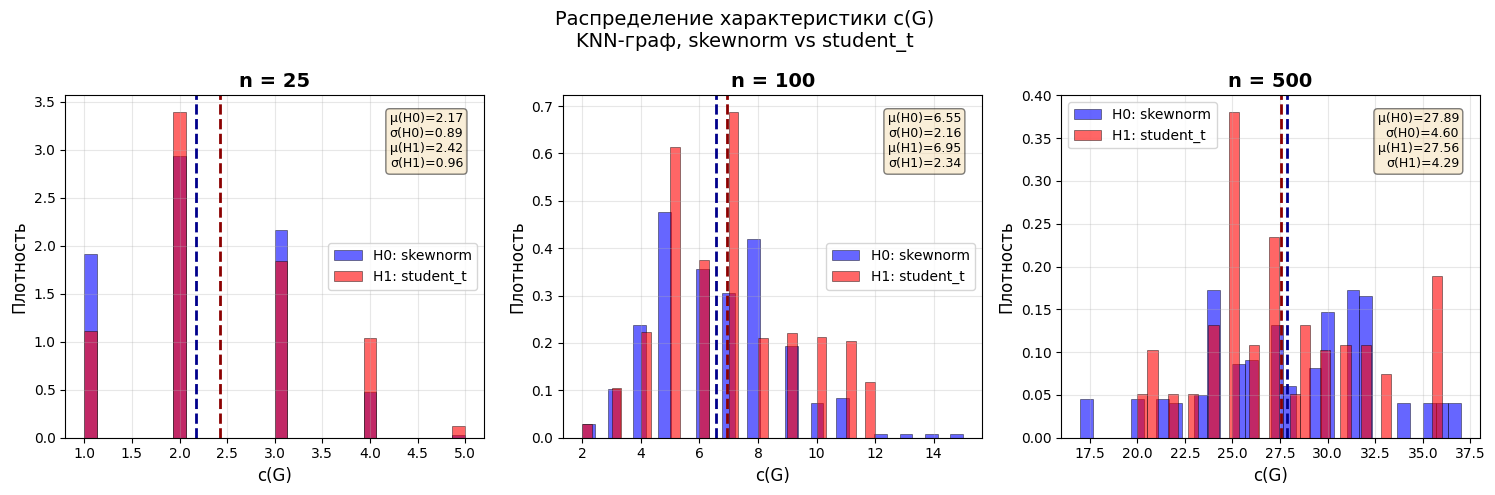

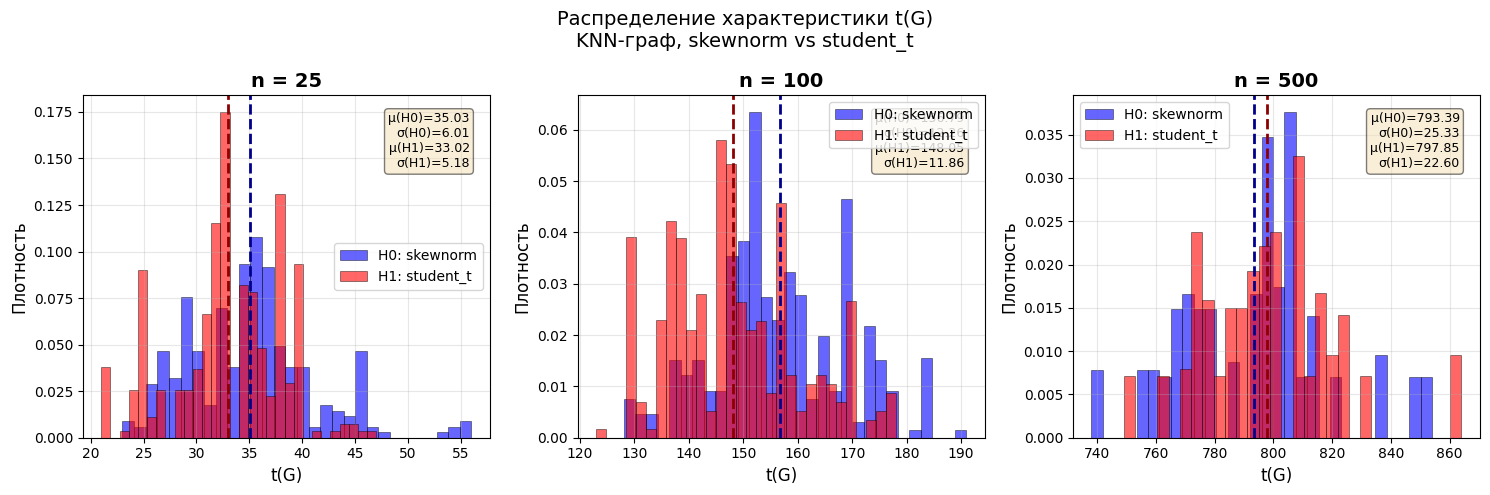

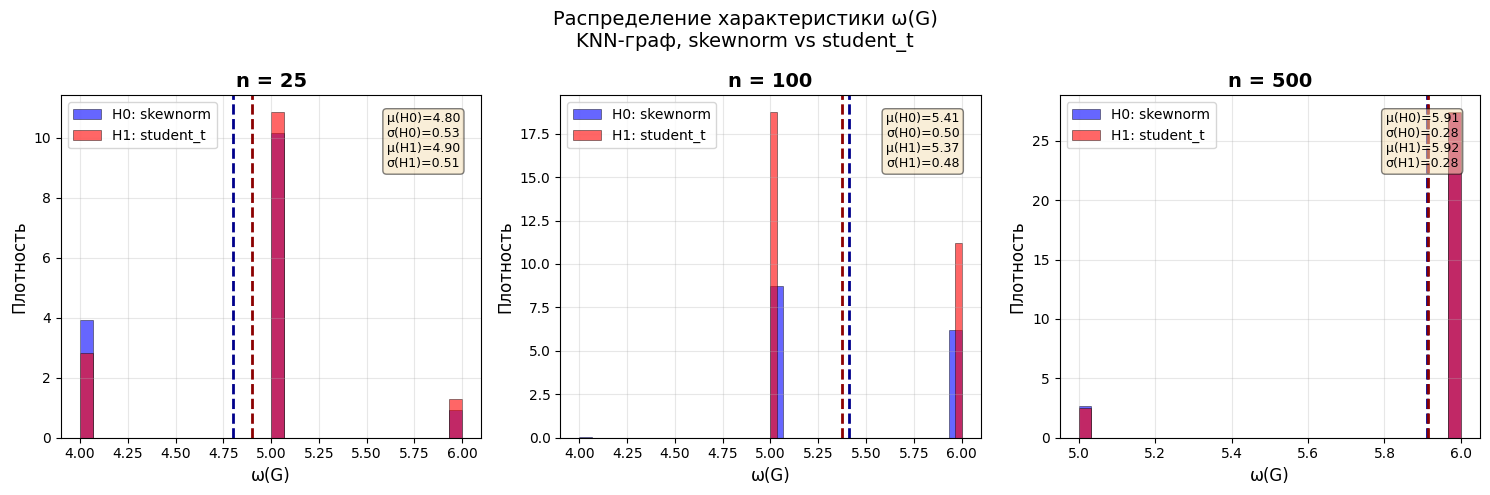

In [16]:
for feature_idx, feature_name in enumerate(FEATURES_TO_USE):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle(
        f"Распределение характеристики {feature_labels.get(feature_name, feature_name)}\n"
        f"{GRAPH_TYPE.upper()}-граф, {DISTRIBUTION_H0} vs {DISTRIBUTION_H1}",
        fontsize=14,
    )

    for idx, n in enumerate(N_VALUES):
        ax = axes[idx]

        # Получаем данные
        X = all_datasets[n]["X"]
        y = all_datasets[n]["y"]
        feature_names = all_datasets[n]["feature_names"]

        # Находим индекс текущей характеристики
        feature_col_idx = feature_names.index(feature_name)

        # Разделяем данные по классам
        X_h0 = X[y == 0, feature_col_idx]
        X_h1 = X[y == 1, feature_col_idx]

        # Определяем количество бинов
        n_bins = min(30, int(np.sqrt(len(X_h0))))

        # Строим гистограммы
        ax.hist(
            X_h0,
            bins=n_bins,
            alpha=0.6,
            label=f"H0: {DISTRIBUTION_H0}",
            color="blue",
            density=True,
            edgecolor="black",
            linewidth=0.5,
        )
        ax.hist(
            X_h1,
            bins=n_bins,
            alpha=0.6,
            label=f"H1: {DISTRIBUTION_H1}",
            color="red",
            density=True,
            edgecolor="black",
            linewidth=0.5,
        )

        # Добавляем статистику
        mean_h0, std_h0 = np.mean(X_h0), np.std(X_h0)
        mean_h1, std_h1 = np.mean(X_h1), np.std(X_h1)

        # Вертикальные линии для средних
        ax.axvline(mean_h0, color="darkblue", linestyle="--", linewidth=2)
        ax.axvline(mean_h1, color="darkred", linestyle="--", linewidth=2)

        # Настройка осей
        ax.set_xlabel(f"{feature_labels.get(feature_name, feature_name)}", fontsize=12)
        ax.set_ylabel("Плотность", fontsize=12)
        ax.set_title(f"n = {n}", fontsize=14, fontweight="bold")
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)

        # Текст со статистикой
        stats_text = f"μ(H0)={mean_h0:.2f}\nσ(H0)={std_h0:.2f}\n"
        stats_text += f"μ(H1)={mean_h1:.2f}\nσ(H1)={std_h1:.2f}"
        ax.text(
            0.95,
            0.95,
            stats_text,
            transform=ax.transAxes,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

In [17]:
print("\n" + "=" * 70)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("=" * 70)

# Найдем лучший классификатор для каждого n
for n in N_VALUES:
    print(f"\n--- Размер выборки n={n} ---")
    
    # Находим классификатор с минимальной ошибкой I рода при α ≤ 0.05
    best_clf = None
    best_power = 0
    
    for clf_name, metrics in detailed_results[n].items():
        type_i_error = metrics['type_i_error']['mean']
        power = metrics['power']['mean']
        
        if type_i_error <= 0.05 and power > best_power:
            best_clf = clf_name
            best_power = power
    
    if best_clf:
        print(f"Лучший классификатор: {best_clf}")
        print(f"  Ошибка I рода: {detailed_results[n][best_clf]['type_i_error']['mean']:.4f}")
        print(f"  Мощность: {detailed_results[n][best_clf]['power']['mean']:.4f}")
    else:
        print("Ни один классификатор не удовлетворяет условию α ≤ 0.05")


ИТОГОВЫЕ ВЫВОДЫ

--- Размер выборки n=25 ---
Ни один классификатор не удовлетворяет условию α ≤ 0.05

--- Размер выборки n=100 ---
Лучший классификатор: Random Forest
  Ошибка I рода: 0.0442
  Мощность: 0.9459

--- Размер выборки n=500 ---
Лучший классификатор: Random Forest
  Ошибка I рода: 0.0000
  Мощность: 1.0000
